In [1]:
from Bayesian_NN import sample_posterior_predictive, construct_nn, construct_minibatch_nn
from data_info import MAPPINGS, CONTINUOUS, CATEGORICAL

import arviz as az
import matplotlib.pyplot as plt
import pytensor
from imblearn.under_sampling import RandomUnderSampler 
import numpy as np
import pandas as pd
import pymc as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.stats import entropy

floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
data = pd.read_csv('Flood Data.csv')
data.rename(columns={'SOIL TYPE': 'LITHOLOGY'}, inplace=True)
data = data.loc[:,'HAZARD 1 IN 1000':]
Y = data['HAZARD 1 IN 1000']
X = data.iloc[:,1:]

X = X.astype(floatX)
Y = Y.astype(floatX)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

print("\nNaN's per Feature:")
print(X.isna().sum()) # NaN counts
print(X.shape)

print("\nPre-Cleaning Label Distributions:")
print((Y.value_counts(normalize=True) * 100).round(2)) # label split

nan_rows = X.isna().any(axis=1).sum()
print(f"\nRows to remove: {nan_rows} of {len(X)} ({(nan_rows/len(X) * 100).round(2)}%)")
X = X.dropna()
Y = Y.loc[X.index]

print("\nPost-Cleaning Label Distributions:")
print((Y.value_counts(normalize=True) * 100).round(2)) # label split



NaN's per Feature:
ELEVATION             797
SLOPE                 998
LANDUSE               866
IMPERVIOUSNESS        678
LITHOLOGY             748
SUBSTRATE             748
NDVI                  905
DISTANCE TO RIVER    1012
BUILDING TYPE         793
DISTANCE TO ROAD     1012
dtype: int64
(67330, 10)

Pre-Cleaning Label Distributions:
HAZARD 1 IN 1000
0.0    93.34
1.0     3.06
2.0     1.87
3.0     1.53
4.0     0.19
Name: proportion, dtype: float64

Rows to remove: 1802 of 67330 (2.68%)

Post-Cleaning Label Distributions:
HAZARD 1 IN 1000
0.0    93.25
1.0     3.12
2.0     1.90
3.0     1.55
4.0     0.18
Name: proportion, dtype: float64


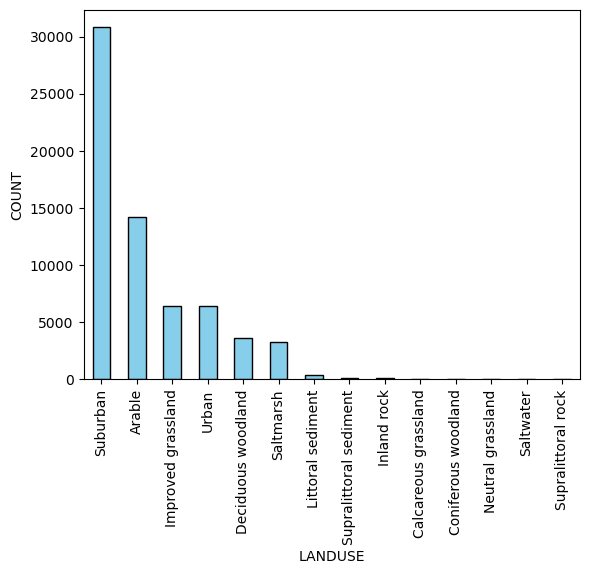

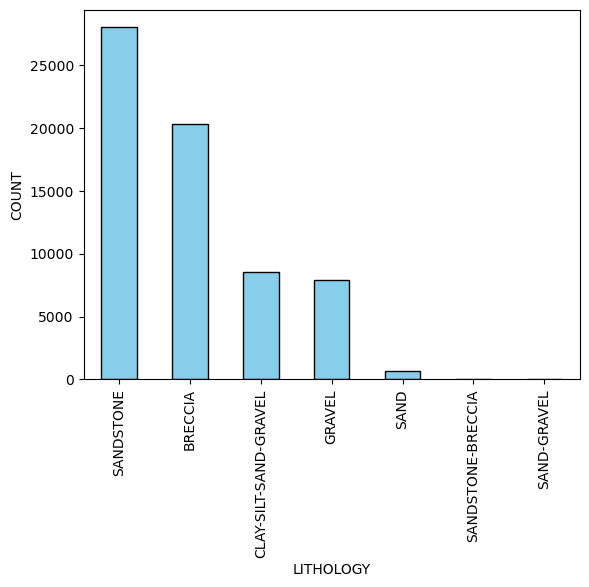

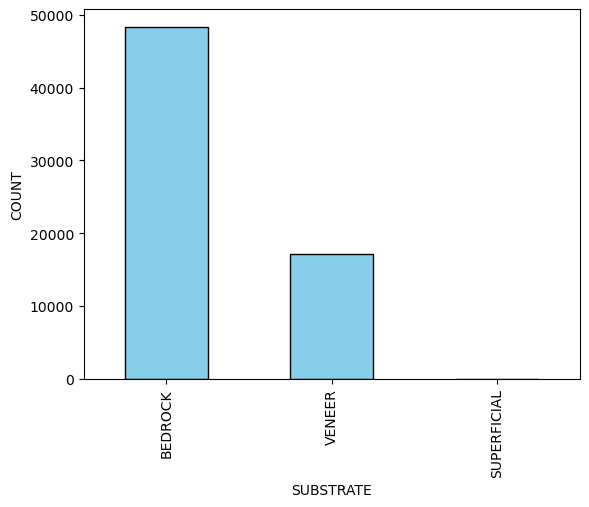

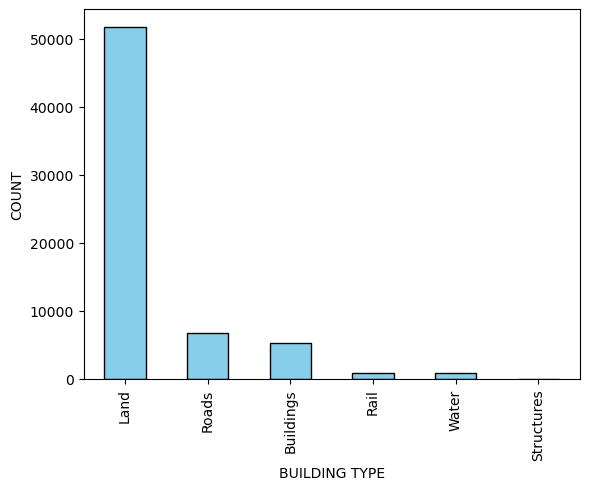

In [4]:
for i in range(len(CATEGORICAL)):
    val_count = X[CATEGORICAL[i]].value_counts(sort=True)
    val_count.index = val_count.index.map(MAPPINGS[i])
    val_count.plot(kind='bar', color="skyblue", edgecolor="black")
    plt.ylabel("COUNT")
    plt.show()

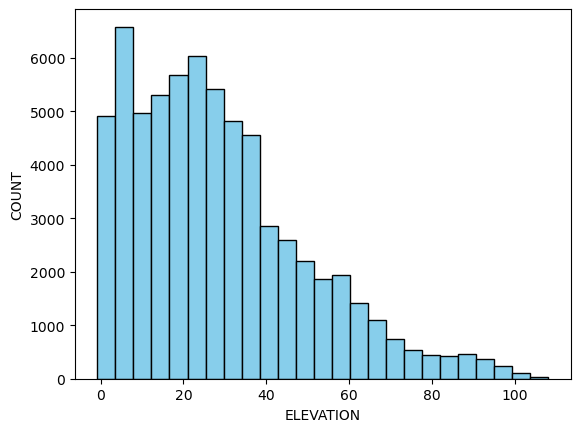

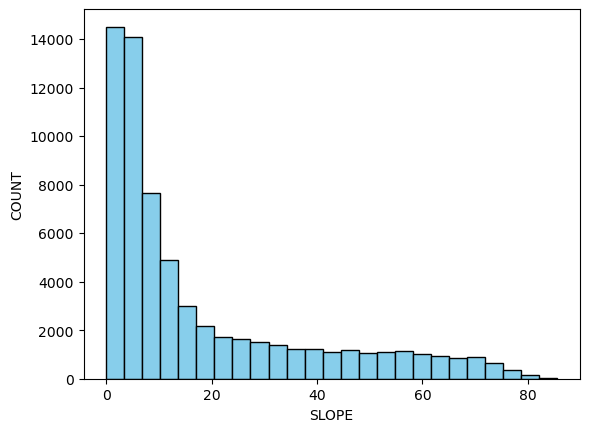

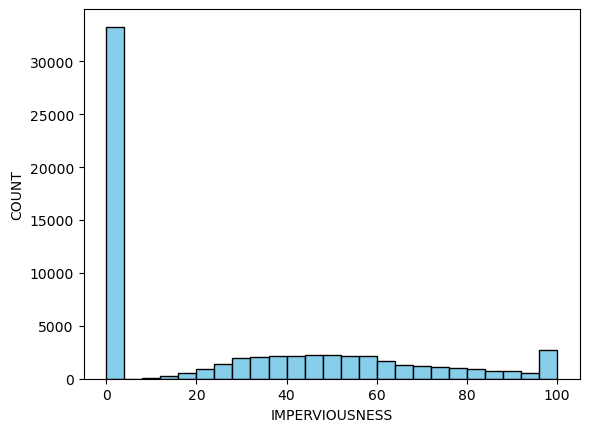

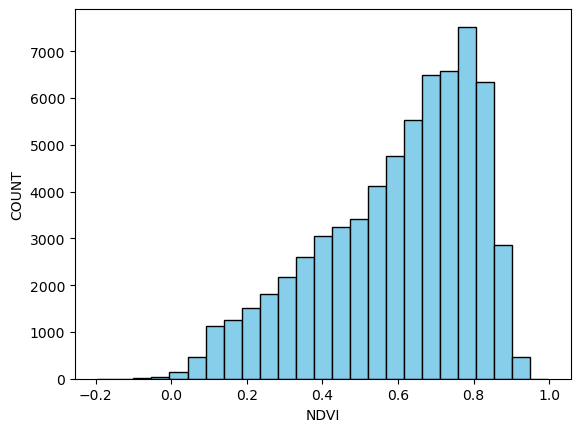

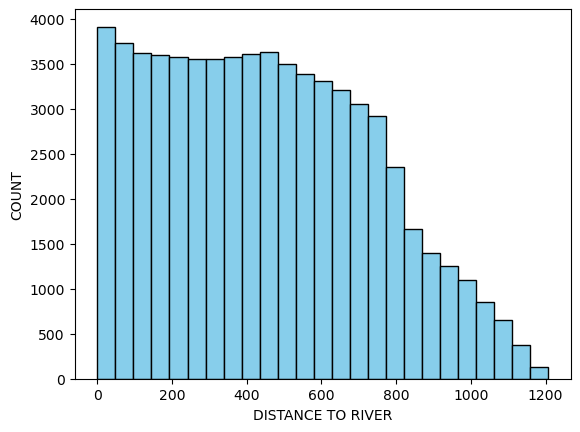

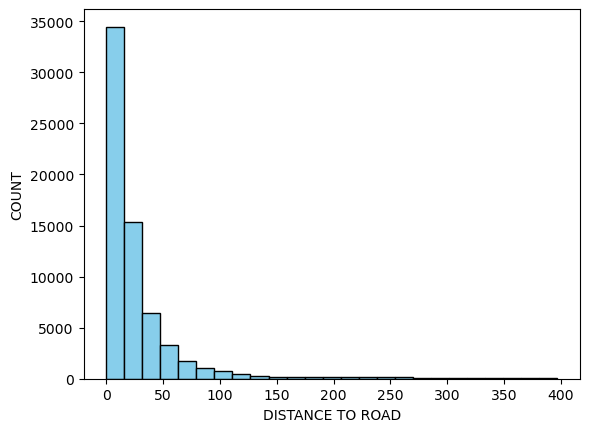

In [5]:
for col in CONTINUOUS:
    plt.hist(X[col], bins = 25, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

### Interpreting the Categorical Data
- SUBSTRATE is an ordinal category; 1 = Bedrock, 2 = Superficial deposit with thin layer, 3 = Superficial deposit - order matters/ bedrock < superficial
- All others are not ordinal so must be OHE
### Interpreting the Continuous Data
- Elevation, slope, and distance to road are logorithmic
- Imperviousness has high number of 0s - more information needed to decide if this should be split into a categorical and continuous feature (i.e. if 0 means something) so will keep as is
- Normalise NDVI
- Standardise all

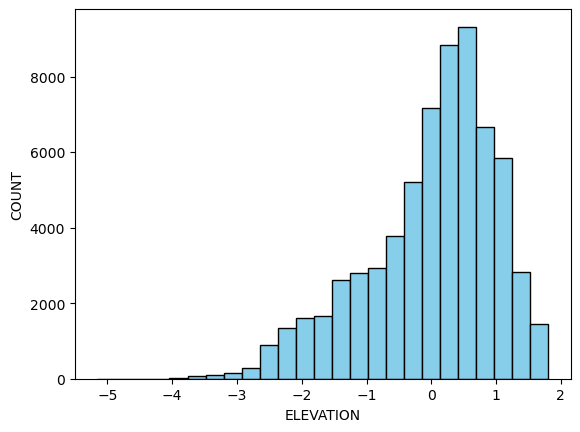

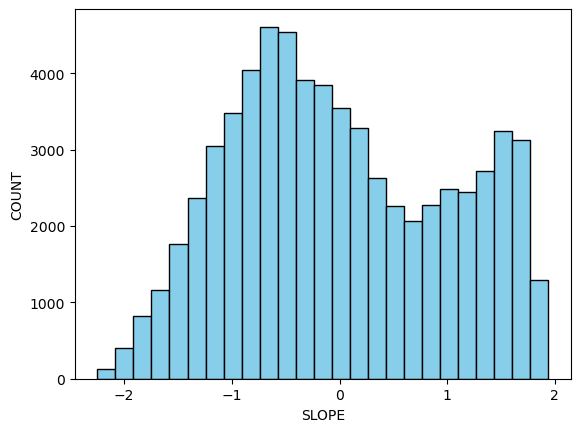

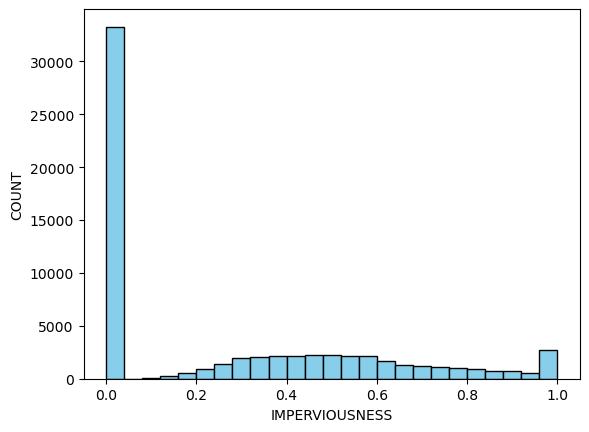

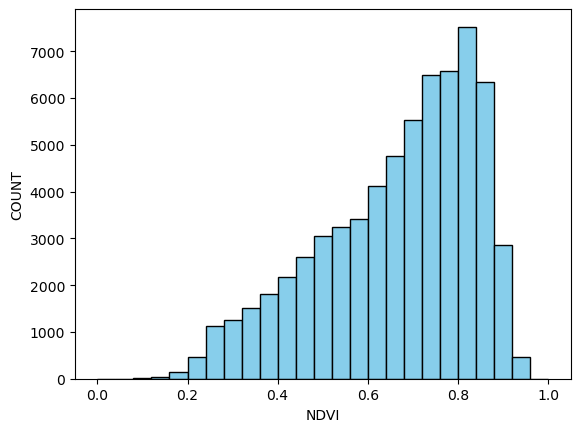

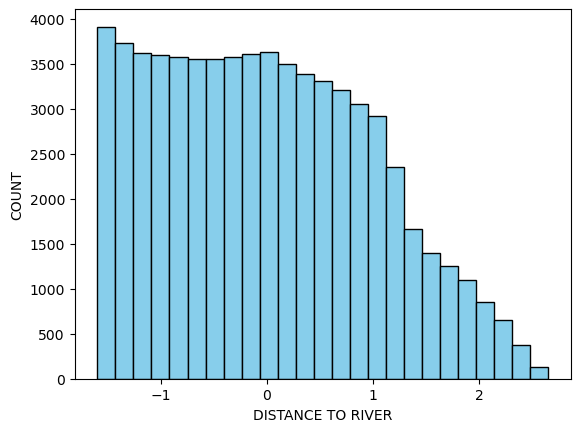

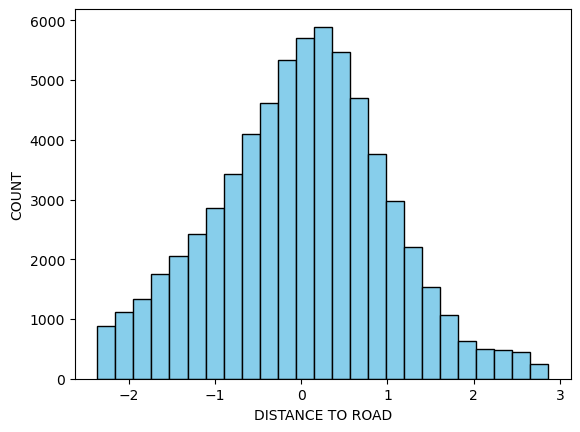

In [6]:
# PREPARE DATA 
LOGORITHMIC = ['ELEVATION','SLOPE', 'DISTANCE TO ROAD']
MIN_MAX = ['IMPERVIOUSNESS', 'NDVI']
STANDARDIZE = list(set(CONTINUOUS) - set(MIN_MAX))
OHE = ["LITHOLOGY", "LANDUSE", "BUILDING TYPE"]

X["NDVI"] = (X["NDVI"] + 1) / 2 # Scales values from [-1,1] to [0,1]

for col in LOGORITHMIC:
    X[col] = np.log1p(X[col])

scalar = MinMaxScaler()
X[MIN_MAX] = scalar.fit_transform(X[MIN_MAX])

scalar = StandardScaler()
X[STANDARDIZE] = scalar.fit_transform(X[STANDARDIZE])

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="first")
encoded_data = encoder.fit_transform(X[OHE])
# Convert to DataFrame and ensure index matches X
encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(OHE), index=X.index)  # ✅ Fix index
X = pd.concat([X.drop(columns=OHE), encoded_data], axis=1)

for col in CONTINUOUS:
    plt.hist(X[col], bins = 25, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

In [50]:
HIDDEN = [5,5]

Y = Y.clip(0,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

rus = RandomUnderSampler()
X_train, Y_train = rus.fit_resample(X_train, Y_train)

print(X_train.shape)
print(X_test.shape)

(6142, 31)
(19659, 31)


Output()

Finished [100%]: Average Loss = 27.113


Text(0.5, 0, 'Iteration')

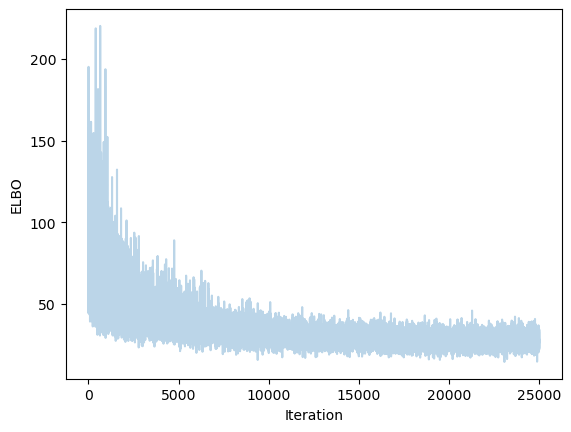

In [51]:
neural_network = construct_minibatch_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

Sampling: [out]


Output()

Test Accuracy: 0.7531
Test Precision: 0.1905
Test Recall: 0.7954


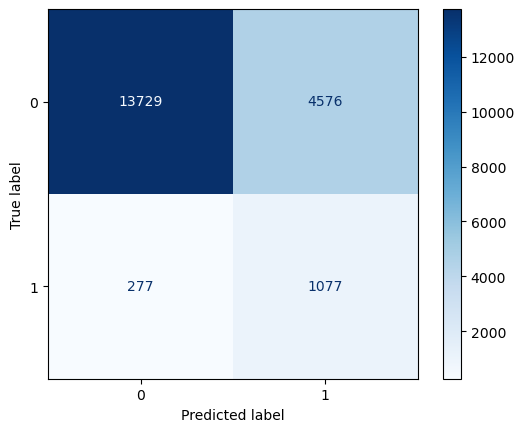

In [10]:
trace_vi_minibatch = approx.sample(draws=2000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi_minibatch, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Output()

Finished [100%]: Average Loss = 2,997.8


Text(0.5, 0, 'Iteration')

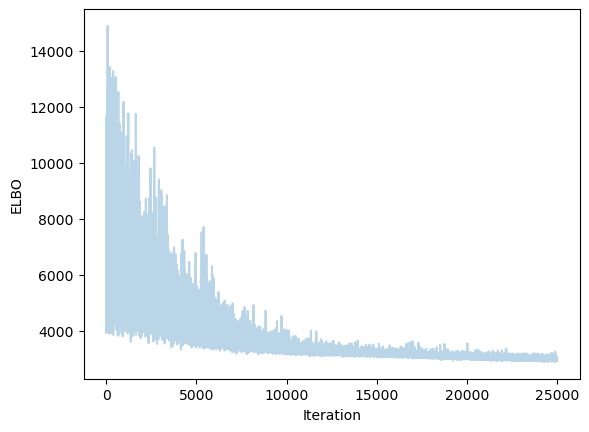

In [52]:
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

Sampling: [out]


Output()

Test Accuracy: 0.7792
Test Precision: 0.2093
Test Recall: 0.7939


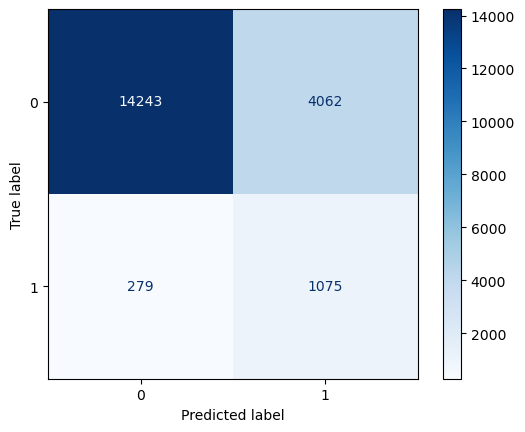

In [26]:
trace_vi = approx.sample(draws=2000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

## MCMC

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 7 seconds.
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 304 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 405 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 1_500 tune and 500 draw iterations (6_000 + 2_000 draws total) took 493 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 590 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 769 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 3_000 tune and 500 draw iterations (12_000 + 2_000 draws total) took 836 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


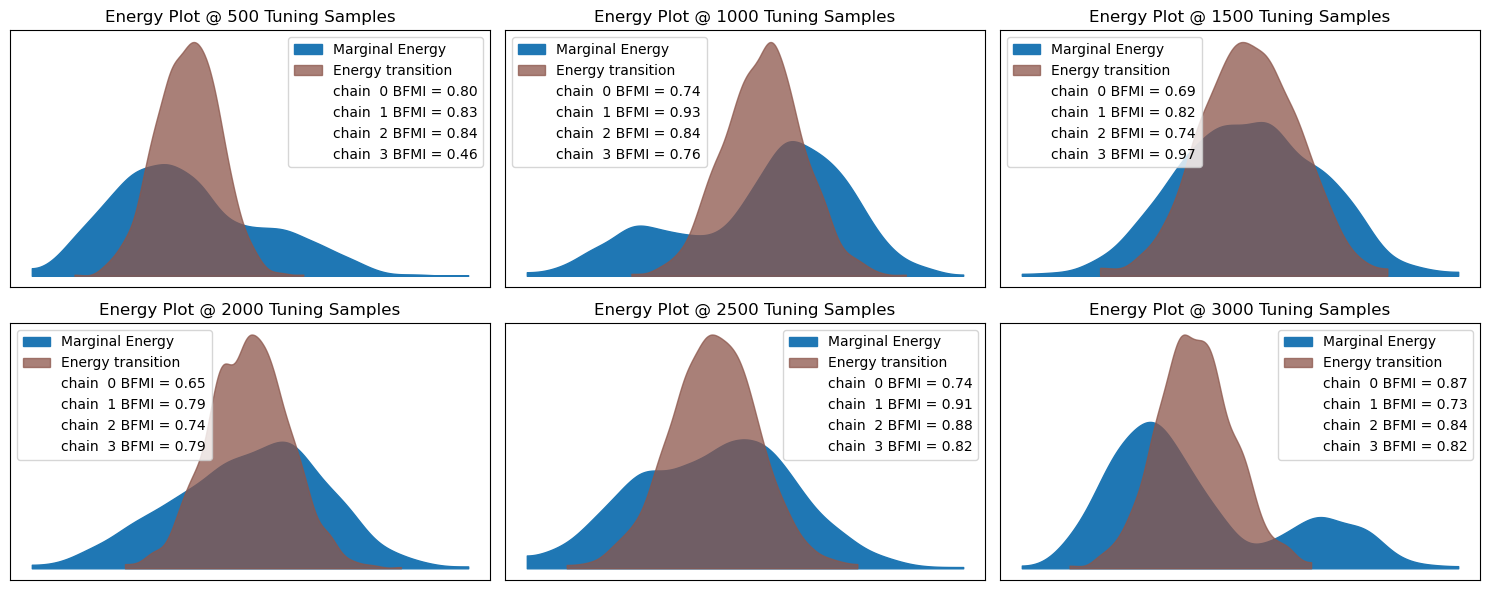

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

tuning_steps = np.arange(0, 3500, 500)

#Run new MCMC chains using different step sizes
traces = []
for tuning_step in tuning_steps:
    with neural_network:
        trace = pm.sample(500, tune=tuning_step, return_inferencedata=True, chains = 4, cores = 4, mp_ctx='spawn')
        traces.append(trace)

# Plot energy distributions to compare efficiency
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # Grid of plots
axes = axes.flatten()
for i, trace in enumerate(traces[1:]):
    pm.plot_energy(trace, ax=axes[i])
    axes[i].set_title(f"Energy Plot @ {tuning_steps[i+1]} Tuning Samples")

plt.tight_layout()
plt.show()

KL Divergence (VI vs MCMC): {'w_0': 0.044, 'w_1': 0.081, 'w_out': inf}
KL Divergence (VI Minibatch vs MCMC): {'w_0': 0.022, 'w_1': 0.166, 'w_out': inf}


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

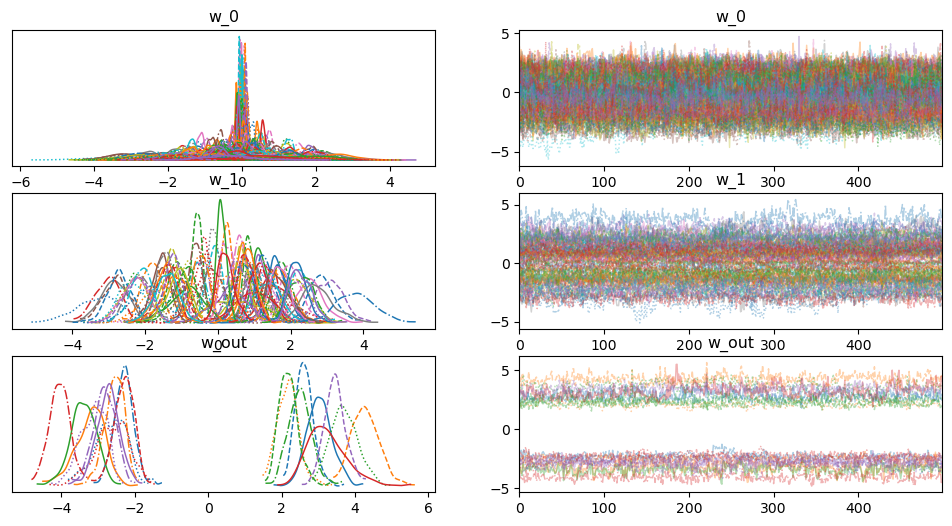

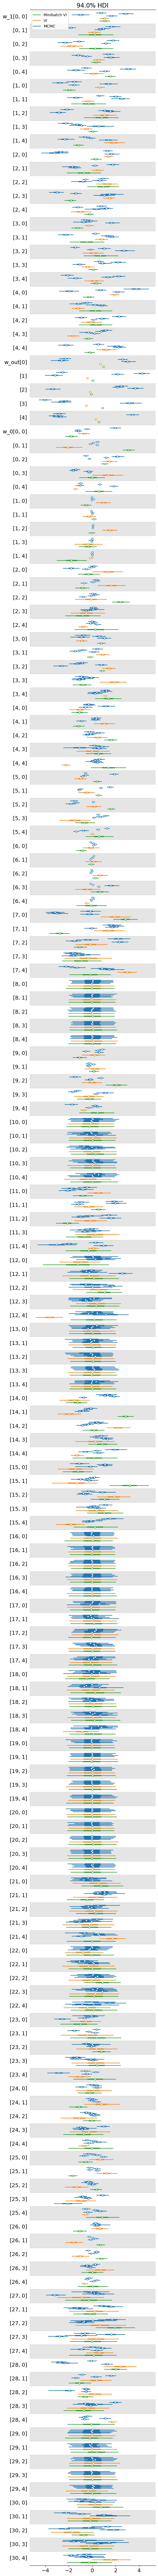

In [ ]:
# Plot the trace (posterior samples of weights)
az.plot_trace(traces[-2])

kl_divs = {}
for weight in traces[-2].posterior.data_vars.keys():
    mcmc_samples = traces[-2].posterior[weight].values.flatten()
    vi_samples = trace_vi.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (VI vs MCMC):", kl_divs)

kl_divs = {}
for weight in traces[-2].posterior.data_vars.keys():
    mcmc_samples = traces[-2].posterior[weight].values.flatten()
    vi_samples = trace_vi_minibatch.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (VI Minibatch vs MCMC):", kl_divs)

az.plot_forest([traces[-2], trace_vi, trace_vi_minibatch], model_names=["MCMC", "VI", "Minibatch VI"], var_names=['w_out'])
az.plot_forest([traces[-2], trace_vi, trace_vi_minibatch], model_names=["MCMC", "VI", "Minibatch VI"], var_names=['w_1'])

Sampling: [out]


Output()

Test Accuracy: 0.8053
Test Precision: 0.2429
Test Recall: 0.8634


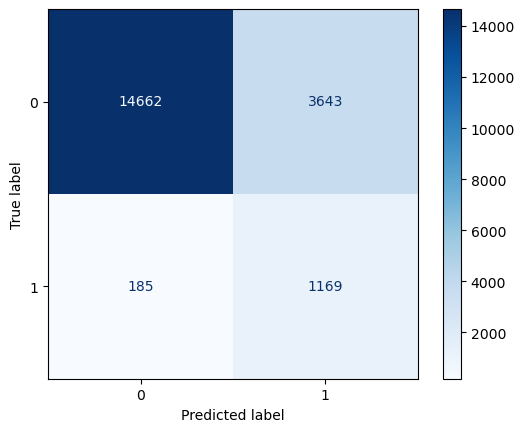

In [19]:
ppc = sample_posterior_predictive(X_test, Y_test, traces[-2], hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

# MCMC with Minibatching

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_2, w_3, w_out]


Output()

Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 56 seconds.
There were 1972 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


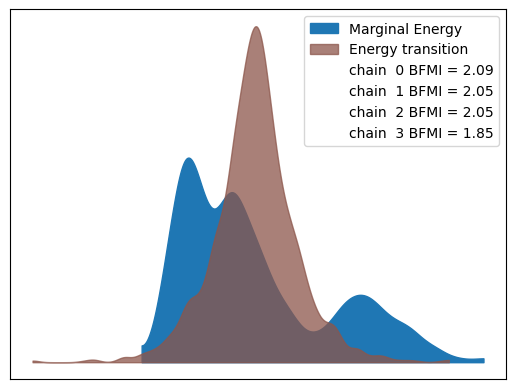

Sampling: [out]


Output()

Test Accuracy: 0.7830
Test Precision: 0.0873
Test Recall: 0.2275
KL Divergence (MCMC Minibatched vs MCMC): {'w_0': 0.333, 'w_1': 0.186, 'w_out': inf}
[[15085  3220]
 [ 1046   308]]


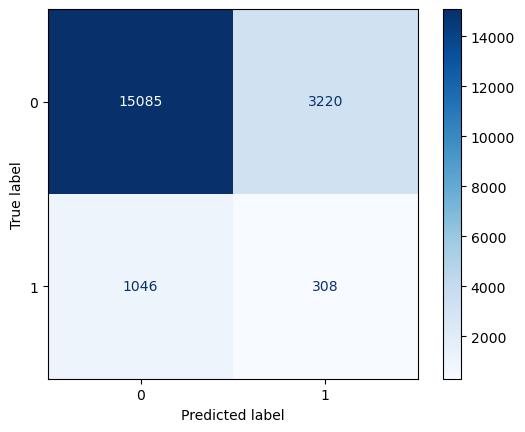

In [ ]:
neural_network = construct_minibatch_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50)

with neural_network:
    trace = pm.sample(500, tune=2500, return_inferencedata=True, chains = 4, cores = 4, mp_ctx='spawn')

pm.plot_energy(trace)
plt.show()

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

kl_divs = {}
for weight in traces[-2].posterior.data_vars.keys():
    mcmc_samples = traces[-2].posterior[weight].values.flatten()
    mcmc_samples_mini = trace.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(mcmc_samples_mini, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (MCMC Minibatched vs MCMC):", kl_divs)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

# Deeper Network

Output()

Finished [100%]: Average Loss = 31.072


Text(0.5, 0, 'Iteration')

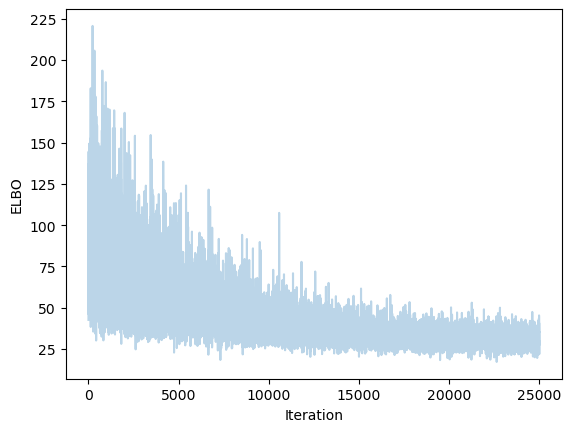

In [48]:
HIDDEN = [10,10,10,10]

neural_network = construct_minibatch_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

Sampling: [out]


Output()

Test Accuracy: 0.7631
Test Precision: 0.1932
Test Recall: 0.7681


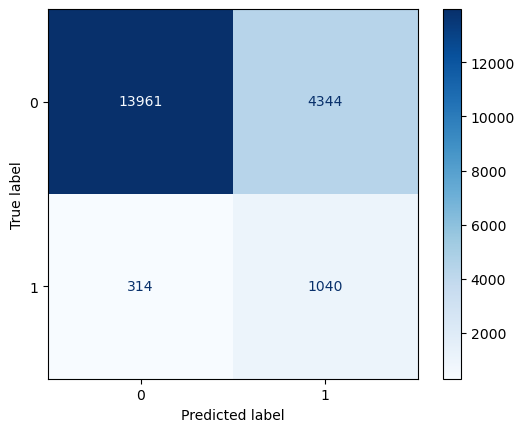

In [36]:
trace_vi_minibatch = approx.sample(draws=2000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi_minibatch, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Output()

Finished [100%]: Average Loss = 3,525.7


Text(0.5, 0, 'Iteration')

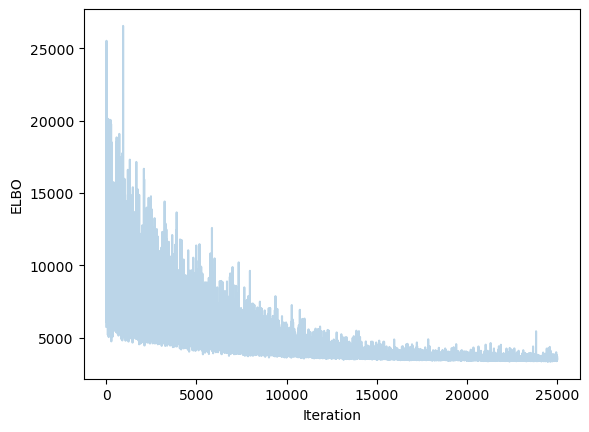

In [49]:
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

Sampling: [out]


Output()

Test Accuracy: 0.7710
Test Precision: 0.2027
Test Recall: 0.7925


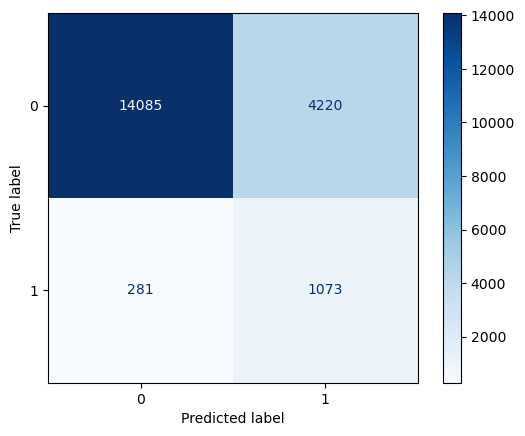

In [38]:
trace_vi = approx.sample(draws=2000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_2, w_3, w_out]


Output()

Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 7805 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


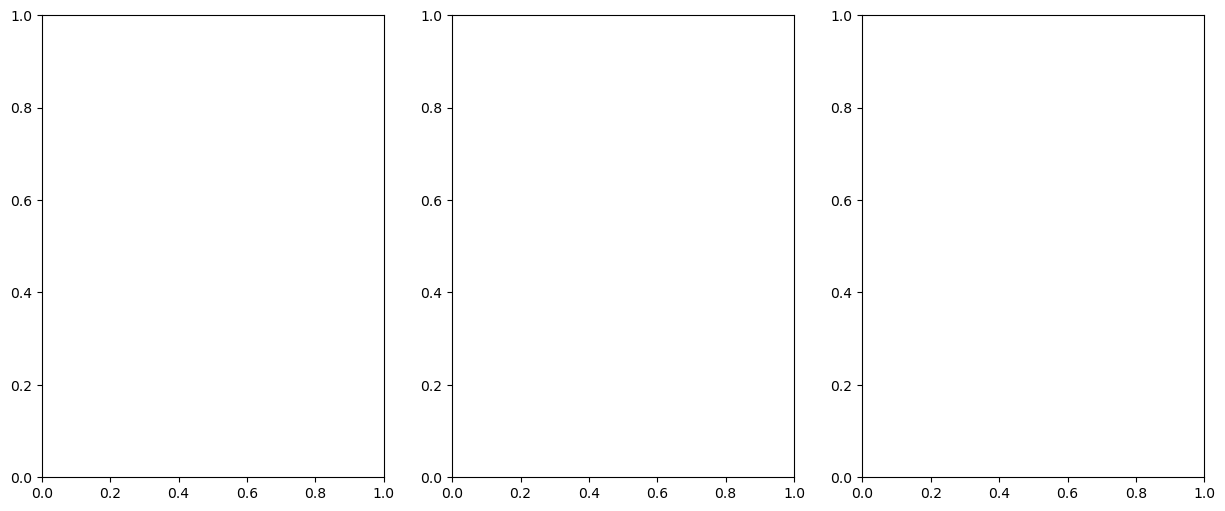

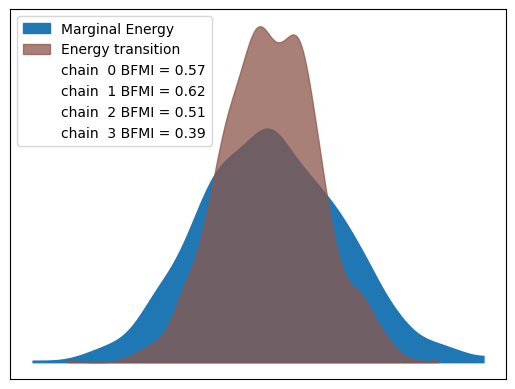

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

with neural_network:
    trace = pm.sample(500, tune=2500, return_inferencedata=True, chains = 4, cores = 4, mp_ctx='spawn')

pm.plot_energy(trace)
plt.show()

KL Divergence (VI vs MCMC): {'w_0': 0.031, 'w_1': 0.018, 'w_2': 0.129, 'w_3': 0.029, 'w_out': 0.636}
KL Divergence (VI Minibatch vs MCMC): {'w_0': 0.032, 'w_1': 0.035, 'w_2': 0.024, 'w_3': inf, 'w_out': 0.364}


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

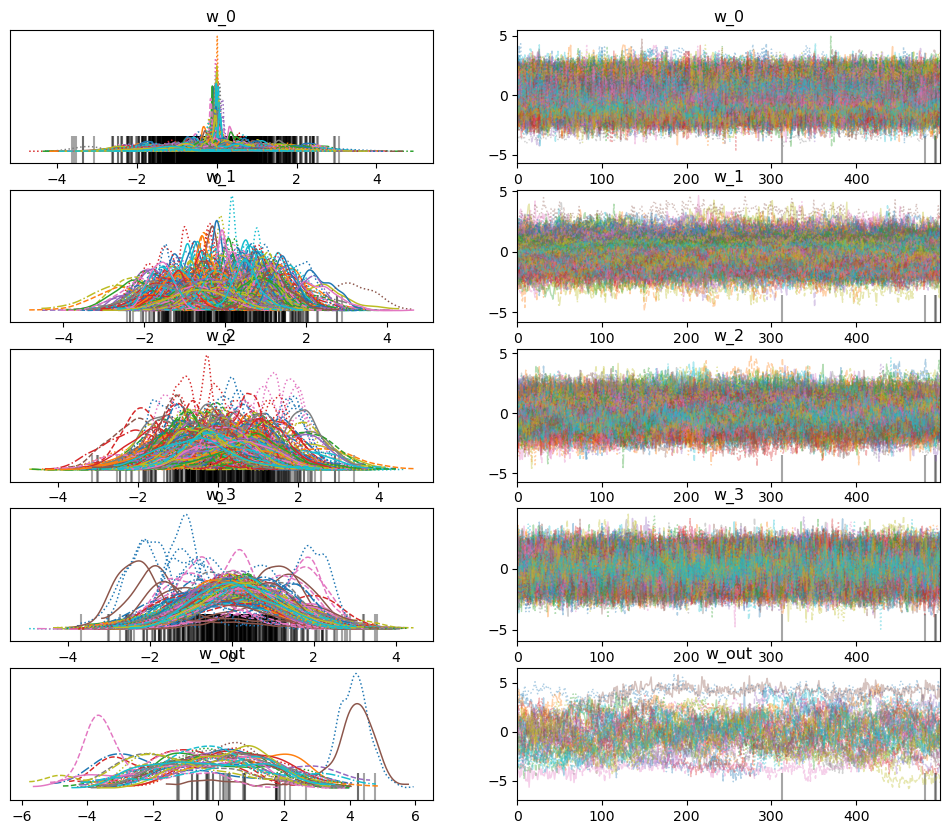

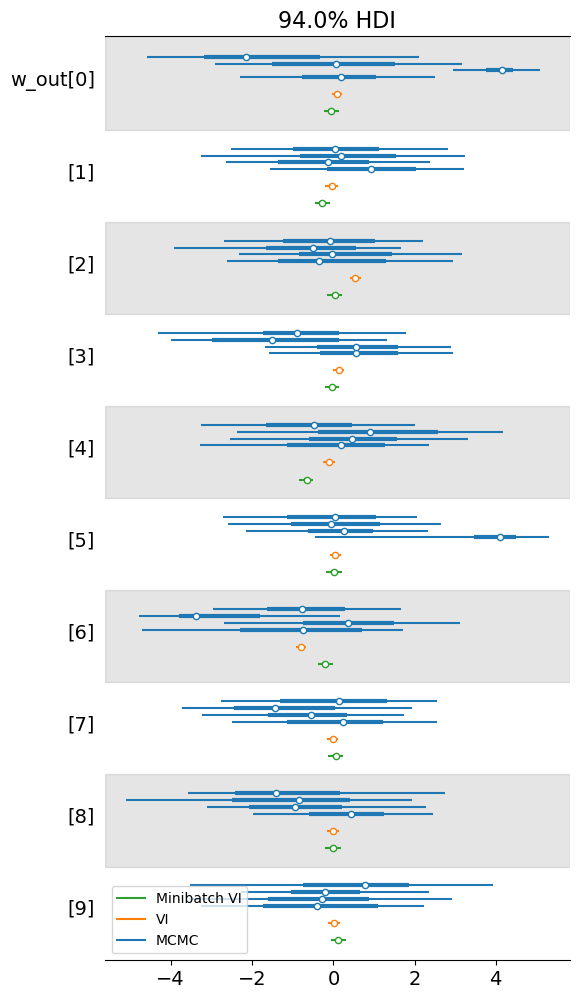

In [43]:
# Plot the trace (posterior samples of weights)
az.plot_trace(trace)

kl_divs = {}
for weight in trace.posterior.data_vars.keys():
    mcmc_samples = trace.posterior[weight].values.flatten()
    vi_samples = trace_vi.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (VI vs MCMC):", kl_divs)

kl_divs = {}
for weight in trace.posterior.data_vars.keys():
    mcmc_samples = trace.posterior[weight].values.flatten()
    vi_samples = trace_vi_minibatch.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (VI Minibatch vs MCMC):", kl_divs)

az.plot_forest([trace, trace_vi, trace_vi_minibatch], model_names=["MCMC", "VI", "Minibatch VI"], var_names="w_out")

Sampling: [out]


Output()

Test Accuracy: 0.8300
Test Precision: 0.2743
Test Recall: 0.8922


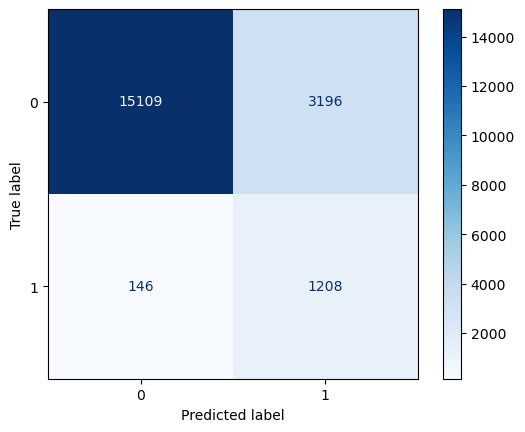

In [41]:
ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

# Wide Distribution

Output()

Finished [100%]: Average Loss = 46.005
Sampling: [out]


Output()

Test Accuracy: 0.8014
Test Precision: 0.1018
Test Recall: 0.2408


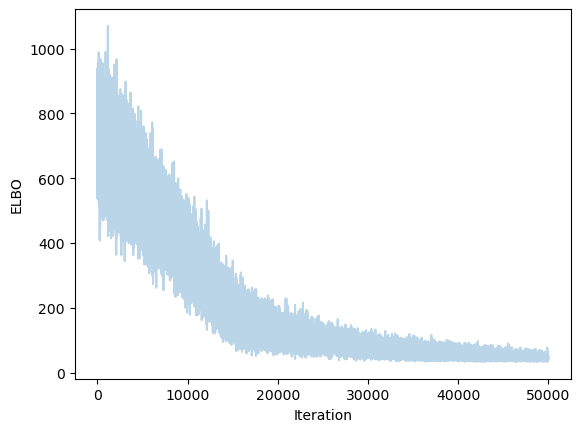

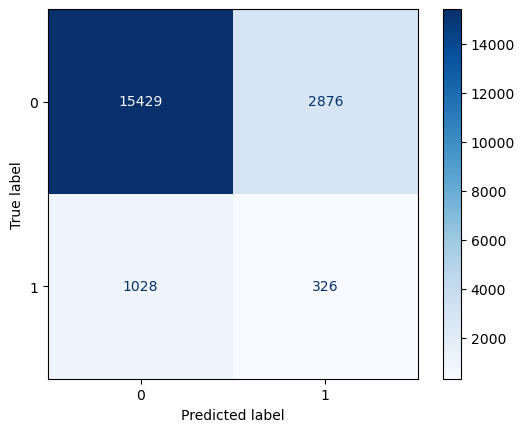

In [46]:
HIDDEN = [5,5]
neural_network = construct_minibatch_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50, sigma = 10, mu = 10)

with neural_network:
    approx = pm.fit(n=50000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

trace_vi_minibatch = approx.sample(draws=2000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi_minibatch, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Output()

Finished [100%]: Average Loss = 57,362
Sampling: [out]


Output()

Test Accuracy: 0.0771
Test Precision: 0.0688
Test Recall: 0.9897


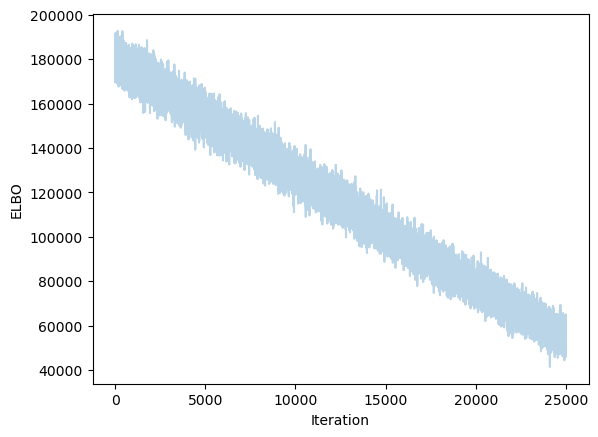

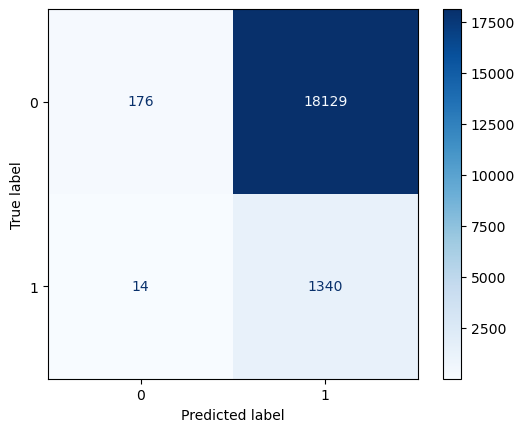

In [47]:
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN, sigma = 10, mu = 10)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

trace_vi = approx.sample(draws=2000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 2618 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


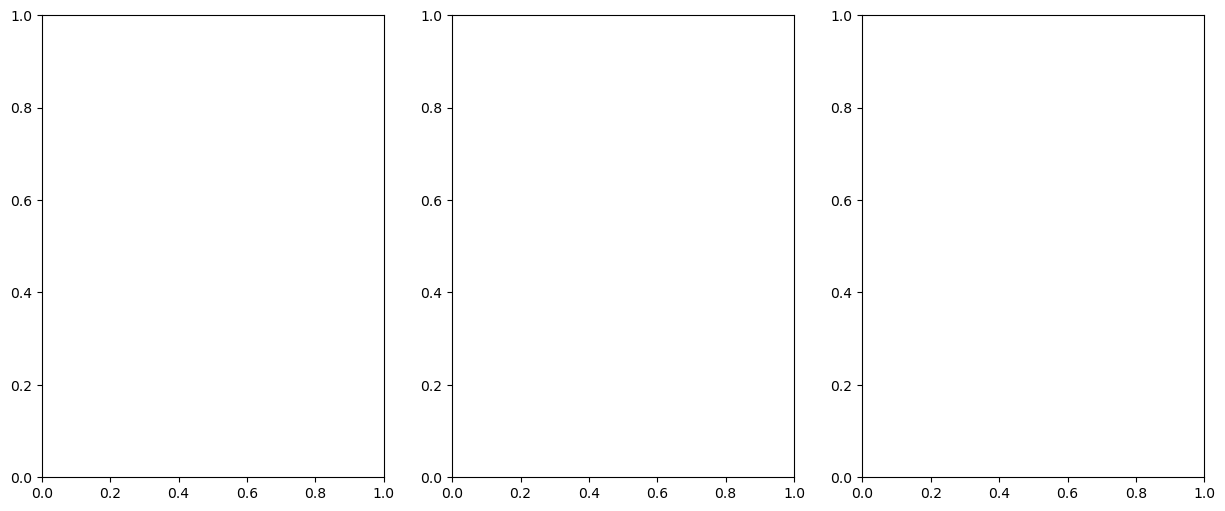

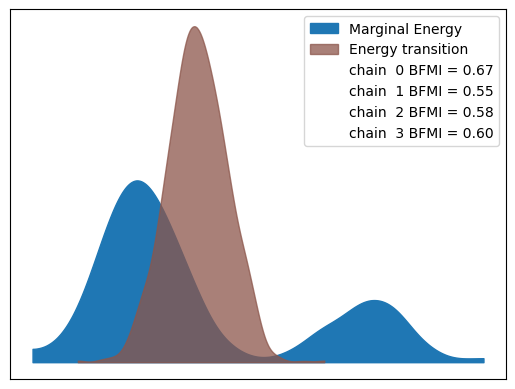

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN, sigma = 10, mu = 10)

with neural_network:
    trace = pm.sample(500, tune=2500, return_inferencedata=True, chains = 4, cores = 4, mp_ctx='spawn')

pm.plot_energy(trace)

plt.show()

Sampling: [out]


Output()

Test Accuracy: 0.8228
Test Precision: 0.2576
Test Recall: 0.8360


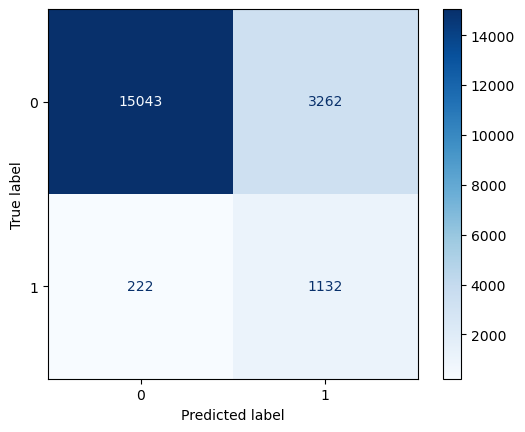

In [23]:
ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
precision = precision_score(Y_test, pred)
recall = recall_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

KL Divergence (VI vs MCMC): {'w_0': 0.031, 'w_1': 0.018, 'w_2': 0.129, 'w_3': 0.029, 'w_out': 0.636}
KL Divergence (VI Minibatch vs MCMC): {'w_0': 0.032, 'w_1': 0.035, 'w_2': 0.024, 'w_3': inf, 'w_out': 0.364}


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

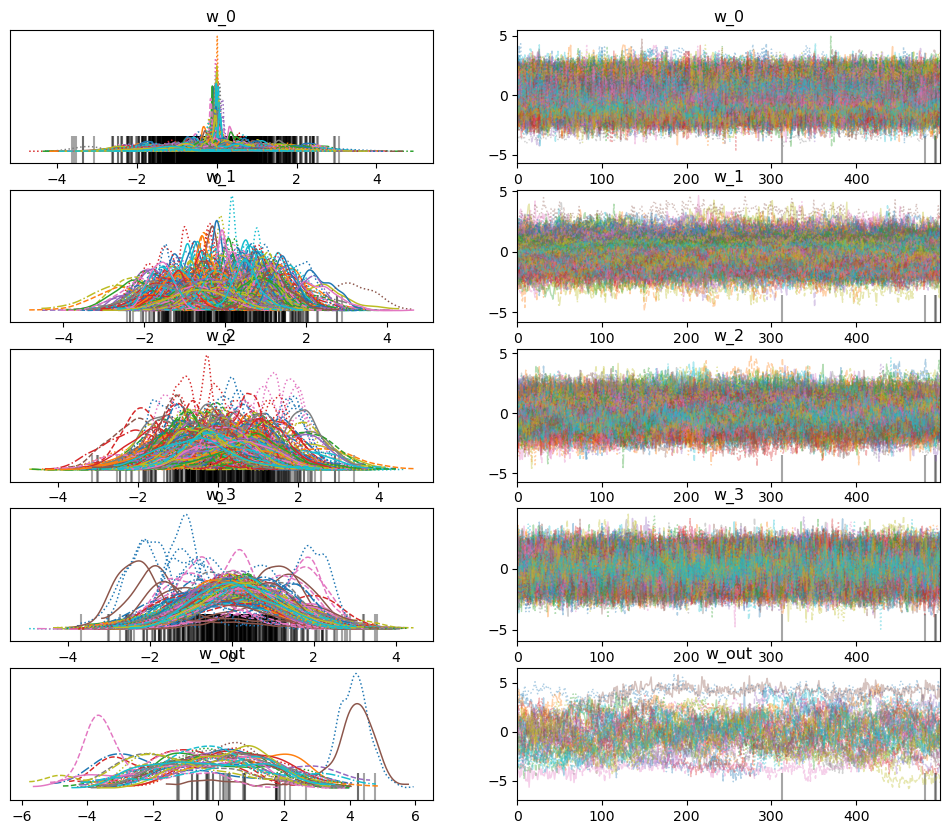

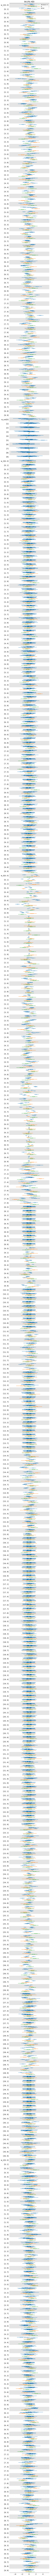

In [44]:
# Plot the trace (posterior samples of weights)
az.plot_trace(trace)

kl_divs = {}
for weight in trace.posterior.data_vars.keys():
    mcmc_samples = trace.posterior[weight].values.flatten()
    vi_samples = trace_vi.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (VI vs MCMC):", kl_divs)

kl_divs = {}
for weight in trace.posterior.data_vars.keys():
    mcmc_samples = trace.posterior[weight].values.flatten()
    vi_samples = trace_vi_minibatch.posterior[weight].values.flatten()
    kl_div = float(entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0]).round(3))
    kl_divs[weight] = kl_div

print("KL Divergence (VI Minibatch vs MCMC):", kl_divs)

az.plot_forest([trace, trace_vi, trace_vi_minibatch], model_names=["MCMC", "VI", "Minibatch VI"])